In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
import numpy as np

In [2]:
class Matryoshka_CE_Loss(nn.Module):
    def __init__(self, relative_importance=None, **kwargs):
        super(Matryoshka_CE_Loss, self).__init__()
        self.criterion = nn.CrossEntropyLoss(**kwargs)
        self.relative_importance = relative_importance

    def forward(self, output, target):
        losses = torch.stack([self.criterion(output_i, target) for output_i in output])
        rel_importance = torch.ones_like(losses) if self.relative_importance is None else torch.as_tensor(self.relative_importance, device=losses.device).clone().detach()        
        weighted_losses = rel_importance * losses
        return weighted_losses.mean()

class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list, num_classes=100, efficient=False, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes
        self.efficient = efficient
        if self.efficient:
            self.nesting_classifier_0 = nn.Linear(nesting_list[-1], self.num_classes, **kwargs)
        else:
            for i, num_feat in enumerate(self.nesting_list):
                setattr(self, f"nesting_classifier_{i}", nn.Linear(num_feat, self.num_classes, **kwargs))

    def forward(self, x):
        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            if self.efficient:
                if self.nesting_classifier_0.bias is None:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()), )
                else:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()) + self.nesting_classifier_0.bias, )
            else:
                nesting_logits += (getattr(self, f"nesting_classifier_{i}")(x[:, :num_feat]),)
        return nesting_logits

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=1)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
nesting_list = [8, 16, 32, 64, 128, 256, 512]
relative_importance = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
relative_importance_tensor = torch.tensor(relative_importance, device=device)
model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = MRL_Linear_Layer(nesting_list, num_classes=100, efficient=False)
model = model.to(device)

In [6]:
def train(epoch):
    model.train()
    train_loss = 0
    correct = {n: 0 for n in nesting_list}
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        for i, n in enumerate(nesting_list):
            _, predicted = outputs[i].max(1)
            correct[n] += predicted.eq(targets).sum().item()
        total += targets.size(0)

    avg_acc = 100. * sum(correct.values()) / (total * len(nesting_list))
    print(f"| {'Train':^6} {epoch:^3} | Loss: {train_loss/(batch_idx+1):^7.3f} | Acc: {avg_acc:^6.3f}% |")

In [7]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct_top1 = {n: 0 for n in nesting_list}
    correct_top5 = {n: 0 for n in nesting_list}
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            for i, n in enumerate(nesting_list):
                _, predicted = outputs[i].max(1)
                correct_top1[n] += predicted.eq(targets).sum().item()
                
                _, top5_pred = outputs[i].topk(5, 1, True, True)
                correct_top5[n] += top5_pred.eq(targets.view(-1, 1)).sum().item()
            
            total += targets.size(0)

    avg_top1 = sum(100. * correct_top1[n] / total for n in nesting_list) / len(nesting_list)
    avg_top5 = sum(100. * correct_top5[n] / total for n in nesting_list) / len(nesting_list)
    
    print("\n┌──────────┬────────────┬────────────┐")
    print(f"│ {'Size':^8} │ {'Top-1 Acc':^10} │ {'Top-5 Acc':^10} │")
    print("├──────────┼────────────┼────────────┤")
    
    for n in nesting_list:
        top1 = 100. * correct_top1[n] / total
        top5 = 100. * correct_top5[n] / total
        print(f"│ {n:^8} │ {top1:>9.2f}% │ {top5:>9.2f}% │")
    
    print("├──────────┼────────────┼────────────┤")
    print(f"│ {'Average':^8} │ {avg_top1:>9.2f}% │ {avg_top5:>9.2f}% │")
    print("└──────────┴────────────┴────────────┘")
    
    return avg_top1 

In [8]:
criterion = Matryoshka_CE_Loss(relative_importance=relative_importance_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

| Train   0  | Loss:  3.948  | Acc: 9.254 % |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │      9.14% │     29.25% │
│    16    │     13.43% │     38.66% │
│    32    │     15.64% │     42.64% │
│    64    │     16.93% │     44.76% │
│   128    │     17.58% │     45.81% │
│   256    │     17.50% │     45.48% │
│   512    │     16.83% │     44.60% │
├──────────┼────────────┼────────────┤
│ Average  │     15.29% │     41.60% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train   1  | Loss:  3.258  | Acc: 19.603% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     15.46% │     43.20% │
│    16    │     21.43% │     51.17% │
│    32    │     23.13% │     53.80% │
│    64    │     23.63% │     54.82% │
│   128    │     24.11% │

| Train  13  | Loss:  1.880  | Acc: 48.959% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     37.66% │     69.12% │
│    16    │     42.33% │     73.47% │
│    32    │     43.70% │     75.21% │
│    64    │     44.08% │     75.48% │
│   128    │     44.18% │     75.53% │
│   256    │     44.29% │     75.57% │
│   512    │     44.34% │     75.65% │
├──────────┼────────────┼────────────┤
│ Average  │     42.94% │     74.29% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  14  | Loss:  1.849  | Acc: 49.650% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     35.50% │     65.16% │
│    16    │     41.12% │     71.05% │
│    32    │     43.51% │     72.60% │
│    64    │     43.66% │     73.34% │
│   128    │     43.66% │

| Train  26  | Loss:  1.660  | Acc: 54.606% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     42.94% │     72.94% │
│    16    │     48.98% │     78.03% │
│    32    │     50.64% │     80.08% │
│    64    │     51.28% │     80.69% │
│   128    │     51.38% │     80.87% │
│   256    │     51.30% │     80.96% │
│   512    │     51.37% │     80.96% │
├──────────┼────────────┼────────────┤
│ Average  │     49.70% │     79.22% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  27  | Loss:  1.641  | Acc: 54.969% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     43.69% │     72.65% │
│    16    │     49.55% │     78.57% │
│    32    │     51.11% │     80.40% │
│    64    │     51.61% │     81.05% │
│   128    │     51.63% │

| Train  39  | Loss:  1.559  | Acc: 57.329% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     42.77% │     71.89% │
│    16    │     49.14% │     77.93% │
│    32    │     50.51% │     80.37% │
│    64    │     51.15% │     80.74% │
│   128    │     51.21% │     80.97% │
│   256    │     51.20% │     80.92% │
│   512    │     51.21% │     80.90% │
├──────────┼────────────┼────────────┤
│ Average  │     49.60% │     79.10% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  40  | Loss:  1.544  | Acc: 57.964% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     46.24% │     74.28% │
│    16    │     51.77% │     78.94% │
│    32    │     52.79% │     80.56% │
│    64    │     53.38% │     81.33% │
│   128    │     53.47% │

| Train  52  | Loss:  1.477  | Acc: 59.563% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     46.72% │     74.85% │
│    16    │     53.58% │     80.48% │
│    32    │     54.94% │     82.29% │
│    64    │     55.37% │     82.76% │
│   128    │     55.48% │     82.92% │
│   256    │     55.52% │     82.96% │
│   512    │     55.54% │     82.97% │
├──────────┼────────────┼────────────┤
│ Average  │     53.88% │     81.32% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  53  | Loss:  1.466  | Acc: 59.597% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     45.90% │     73.36% │
│    16    │     50.88% │     78.20% │
│    32    │     52.08% │     79.83% │
│    64    │     52.62% │     80.52% │
│   128    │     52.59% │

| Train  65  | Loss:  1.385  | Acc: 61.720% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     48.90% │     76.78% │
│    16    │     53.87% │     81.26% │
│    32    │     55.52% │     82.94% │
│    64    │     55.67% │     83.27% │
│   128    │     55.63% │     83.24% │
│   256    │     55.70% │     83.29% │
│   512    │     55.71% │     83.30% │
├──────────┼────────────┼────────────┤
│ Average  │     54.43% │     82.01% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  66  | Loss:  1.375  | Acc: 62.006% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     46.37% │     73.32% │
│    16    │     51.30% │     78.57% │
│    32    │     52.36% │     80.69% │
│    64    │     52.94% │     81.26% │
│   128    │     53.05% │

| Train  78  | Loss:  1.284  | Acc: 64.570% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     51.33% │     77.48% │
│    16    │     55.80% │     81.55% │
│    32    │     57.83% │     83.76% │
│    64    │     58.02% │     84.45% │
│   128    │     58.19% │     84.64% │
│   256    │     58.20% │     84.70% │
│   512    │     58.18% │     84.73% │
├──────────┼────────────┼────────────┤
│ Average  │     56.79% │     83.04% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  79  | Loss:  1.292  | Acc: 64.321% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     51.92% │     78.82% │
│    16    │     57.24% │     83.24% │
│    32    │     58.79% │     85.02% │
│    64    │     59.17% │     85.32% │
│   128    │     59.08% │

| Train  91  | Loss:  1.175  | Acc: 67.451% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     49.73% │     75.90% │
│    16    │     54.79% │     80.50% │
│    32    │     56.05% │     82.24% │
│    64    │     56.61% │     82.93% │
│   128    │     56.77% │     82.97% │
│   256    │     56.71% │     82.98% │
│   512    │     56.73% │     82.97% │
├──────────┼────────────┼────────────┤
│ Average  │     55.34% │     81.50% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  92  | Loss:  1.167  | Acc: 67.534% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     50.95% │     75.24% │
│    16    │     55.38% │     80.63% │
│    32    │     56.53% │     82.50% │
│    64    │     56.80% │     82.88% │
│   128    │     56.71% │

| Train  104 | Loss:  1.052  | Acc: 70.614% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     53.25% │     78.67% │
│    16    │     57.96% │     82.80% │
│    32    │     59.00% │     84.68% │
│    64    │     59.17% │     85.02% │
│   128    │     59.22% │     85.11% │
│   256    │     59.17% │     85.16% │
│   512    │     59.22% │     85.15% │
├──────────┼────────────┼────────────┤
│ Average  │     58.14% │     83.80% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  105 | Loss:  1.033  | Acc: 70.916% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     53.10% │     78.99% │
│    16    │     57.70% │     83.05% │
│    32    │     58.93% │     85.01% │
│    64    │     59.48% │     85.52% │
│   128    │     59.58% │

| Train  117 | Loss:  0.884  | Acc: 74.847% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     54.82% │     78.66% │
│    16    │     59.30% │     83.12% │
│    32    │     60.39% │     84.95% │
│    64    │     60.64% │     85.45% │
│   128    │     60.64% │     85.62% │
│   256    │     60.65% │     85.63% │
│   512    │     60.69% │     85.59% │
├──────────┼────────────┼────────────┤
│ Average  │     59.59% │     84.15% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  118 | Loss:  0.879  | Acc: 75.069% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     57.10% │     79.68% │
│    16    │     60.52% │     83.59% │
│    32    │     61.39% │     85.70% │
│    64    │     61.55% │     86.13% │
│   128    │     61.57% │

| Train  130 | Loss:  0.718  | Acc: 79.423% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     58.33% │     80.33% │
│    16    │     61.19% │     83.93% │
│    32    │     62.50% │     85.55% │
│    64    │     62.59% │     85.97% │
│   128    │     62.65% │     86.16% │
│   256    │     62.66% │     86.18% │
│   512    │     62.64% │     86.17% │
├──────────┼────────────┼────────────┤
│ Average  │     61.79% │     84.90% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  131 | Loss:  0.699  | Acc: 80.049% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     57.99% │     79.94% │
│    16    │     61.00% │     84.13% │
│    32    │     61.89% │     85.39% │
│    64    │     61.85% │     85.85% │
│   128    │     61.84% │

| Train  143 | Loss:  0.492  | Acc: 85.822% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     60.18% │     81.03% │
│    16    │     63.54% │     85.00% │
│    32    │     64.63% │     86.68% │
│    64    │     64.49% │     86.97% │
│   128    │     64.54% │     87.00% │
│   256    │     64.56% │     87.00% │
│   512    │     64.58% │     86.99% │
├──────────┼────────────┼────────────┤
│ Average  │     63.79% │     85.81% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  144 | Loss:  0.478  | Acc: 86.414% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     61.45% │     82.12% │
│    16    │     64.49% │     85.56% │
│    32    │     65.14% │     87.37% │
│    64    │     65.35% │     87.76% │
│   128    │     65.37% │

| Train  156 | Loss:  0.266  | Acc: 92.606% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     63.96% │     82.89% │
│    16    │     66.60% │     86.21% │
│    32    │     67.18% │     87.95% │
│    64    │     67.45% │     88.38% │
│   128    │     67.46% │     88.35% │
│   256    │     67.48% │     88.36% │
│   512    │     67.49% │     88.37% │
├──────────┼────────────┼────────────┤
│ Average  │     66.80% │     87.22% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  157 | Loss:  0.259  | Acc: 92.911% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     64.07% │     83.44% │
│    16    │     66.73% │     86.36% │
│    32    │     67.35% │     87.92% │
│    64    │     67.62% │     88.34% │
│   128    │     67.57% │

| Train  169 | Loss:  0.099  | Acc: 97.786% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     67.08% │     84.17% │
│    16    │     68.75% │     87.29% │
│    32    │     69.43% │     89.03% │
│    64    │     69.47% │     89.39% │
│   128    │     69.45% │     89.42% │
│   256    │     69.45% │     89.44% │
│   512    │     69.46% │     89.45% │
├──────────┼────────────┼────────────┤
│ Average  │     69.01% │     88.31% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  170 | Loss:  0.085  | Acc: 98.245% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     68.04% │     84.48% │
│    16    │     69.58% │     87.33% │
│    32    │     70.08% │     88.86% │
│    64    │     70.17% │     89.28% │
│   128    │     70.17% │

| Train  182 | Loss:  0.038  | Acc: 99.581% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     69.71% │     85.21% │
│    16    │     71.31% │     88.08% │
│    32    │     71.57% │     89.59% │
│    64    │     71.75% │     90.00% │
│   128    │     71.77% │     90.09% │
│   256    │     71.76% │     90.10% │
│   512    │     71.76% │     90.08% │
├──────────┼────────────┼────────────┤
│ Average  │     71.38% │     89.02% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  183 | Loss:  0.036  | Acc: 99.659% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     69.55% │     85.35% │
│    16    │     71.02% │     87.93% │
│    32    │     71.72% │     89.69% │
│    64    │     71.68% │     89.91% │
│   128    │     71.74% │

| Train  195 | Loss:  0.031  | Acc: 99.753% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     70.16% │     85.56% │
│    16    │     71.62% │     88.11% │
│    32    │     71.87% │     89.62% │
│    64    │     71.97% │     90.10% │
│   128    │     71.98% │     90.16% │
│   256    │     71.99% │     90.15% │
│   512    │     71.99% │     90.17% │
├──────────┼────────────┼────────────┤
│ Average  │     71.65% │     89.12% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  196 | Loss:  0.030  | Acc: 99.797% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     69.88% │     85.63% │
│    16    │     71.55% │     88.35% │
│    32    │     71.76% │     89.84% │
│    64    │     71.93% │     90.26% │
│   128    │     71.92% │

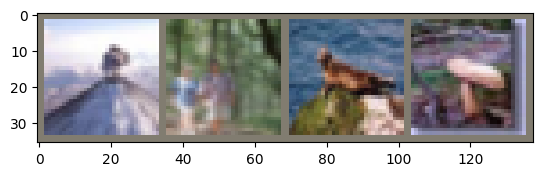

GroundTruth:	 49	33	72	51
Size		Image 1	Image 2	Image 3	Image 4
8		90	33	55	51
16		90	88	55	51
32		68	88	55	51
64		68	88	55	51
128		68	88	55	51
256		68	88	55	51
512		68	88	55	51


In [9]:
import time
from datetime import timedelta

total_start_time = time.time()
epoch_times = []

best_acc = 0
for epoch in range(200):
    epoch_start = time.time()
    train(epoch)
    acc = test(epoch)
    scheduler.step()
    
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_model_mrlMEAN.pth')
    print(f'Epoch time: {timedelta(seconds=int(epoch_time))}')
    print('-' * 80)

total_time = time.time() - total_start_time
print(f'Total training time: {timedelta(seconds=int(total_time))}')
print(f'Average epoch time: {timedelta(seconds=int(sum(epoch_times)/len(epoch_times)))}')    

print(f'Best Test Accuracy: {best_acc:.2f}%')

import matplotlib.pyplot as plt
def imshow(img):
    img = img * torch.tensor([0.2675, 0.2565, 0.2761]).view(3, 1, 1) + \
          torch.tensor([0.5071, 0.4867, 0.4408]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:\t', '\t'.join(f'{labels[j]}' for j in range(4)))

print("Size\t\t" + "\t".join(f"Image {j+1}" for j in range(4)))
outputs = model(images[:4].to(device))
for i, n in enumerate(nesting_list):
    _, predicted = torch.max(outputs[i], 1)
    print(f"{n}\t\t" + "\t".join(f"{predicted[j].item()}" for j in range(4)))